# Анализ процесса выплавки стали

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels

In [2]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)
print(statsmodels.__version__)

1.3.5
1.22.3
0.11.2
0.13.1


### Загрузка данных

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 57 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   melt_id      60 non-null     object 
 1   furnace      60 non-null     object 
 2   n_items      60 non-null     int64  
 3   n_defects    60 non-null     int64  
 4   melt_volume  60 non-null     float64
 5   FeSiMn       29 non-null     float64
 6   FeMn         8 non-null      float64
 7   FeSi         47 non-null     float64
 8   CaSi         60 non-null     float64
 9   FeTi         60 non-null     float64
 10  AB           60 non-null     float64
 11  C_0          60 non-null     float64
 12  Mn_0         60 non-null     float64
 13  Si_0         30 non-null     float64
 14  P_0          60 non-null     float64
 15  S_0          60 non-null     float64
 16  Cr_0         60 non-null     float64
 17  Ni_0         28 non-null     float64
 18  Cu_0         28 non-null     float64
 19  C_1       

### Описание признаков

* melt_id – номер плавки
* furnace – плавильная печь: open-hearth – мартеновская печь; EAF – электродуговая печь
* n_items – общее число отливок с одной плавки
* n_defects – число забракованных отливок с одной плавки
* melt_volume – объем жидкой стали в печи
* FeSiMn, FeMn, FeSi, CaSi, FeTi, AB – расход соответствующих ферросплавов
    
| Сплав  | Марка  | C | Mn | Si  | Ca | Ti | Al | 
| ------ | ------ | - | -- | --  | -- | -- | -- |
| FeSiMn | МнС-17 |   | 70 | 17  |    |    |    |
| FeMn   | ФМн-78 | 6 | 78 |     |    |    |    |
| FeSi   | ФС-45  |   |    | 45  |    |    |    |
| CaSi   | СК-15  |   |    | 53  | 18 |    |    |
| FeTi   | ФТи-35 |   |    | 4.5 |    | 30 |    |
| AB     | АВ-87  |   |    |     |    |    | 87 |

* C, Mn, Si, P, S, Cr, Ni, Cu, Ti, Al – химический состав<br/>
Индекс – тип пробы:
    - 0 – по расплаву – после расплавления шихты
    - 1 – перед раскислением – по окончании кипения и десульфурации
    - 2 – перед выпуском – после предварительного раскисления в печи и доводки по химическому составу
    - 3 – ковшевая – после выпуска из печи, окончательного раскисления и модифицирования в ковше
    - без индекса – маркировочная – во время разливки металла с середины ковша через 20-30 минут после ковшевой пробы (образцы для механических испытаний изготовлены из этих проб)
* yield_str – предел текучести
* tensile_str – предел прочности
* elongation – относительное удлинение
* narrowing – относительное сужение
* KCU, KCV – ударная вязкость с U-образным и V-образным надрезом (по 2 образца)

## Распределение элементов в ковшевой и маркировочной пробах

In [5]:
samples = pd.DataFrame(
    np.vstack((
        data.loc[:,'C':'Al'].assign(sample='mark', furnace=data.furnace, melt_id=data.melt_id)\
        .drop(['Ni','Cu'], axis=1).values,
        data.filter(like='_3').assign(sample='ladle', furnace=data.furnace, melt_id=data.melt_id)\
        .values
    )), 
    columns=['C','Mn','Si','P','S','Cr','Ti','Al','sample','furnace','melt_id'])\
.dropna().convert_dtypes()

print(samples.drop('melt_id', axis=1).sample(5))

        C    Mn    Si      P      S    Cr     Ti     Al sample      furnace
12   0.21  1.22  0.31  0.023  0.029  0.12  0.003  0.025   mark  open-hearth
51   0.23  1.26  0.38  0.022  0.026  0.13  0.001  0.036   mark          EAF
104  0.21  1.19  0.34  0.028  0.028   0.1  0.005   0.06  ladle          EAF
102  0.22  1.14  0.33  0.024  0.027  0.12  0.005  0.052  ladle          EAF
91   0.22   1.2  0.26  0.028   0.03  0.13  0.004   0.06  ladle          EAF


Здесь sample – тип пробы: mark – маркировочная; ladle – ковшевая.

In [6]:
def histplot(X, y, bins=12, ncols=4, figsize=(16,8)):
    plt.rcParams['font.size'] = 11
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    nrows = X.shape[1]//ncols + 1
    
    for idx, feature in enumerate(X.columns):       
        plt.subplot(nrows, ncols, idx+1)        
        ax = sns.histplot(data=X.assign(sample=y), x=feature, hue='sample', bins=bins, multiple='stack', kde=True)    
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')

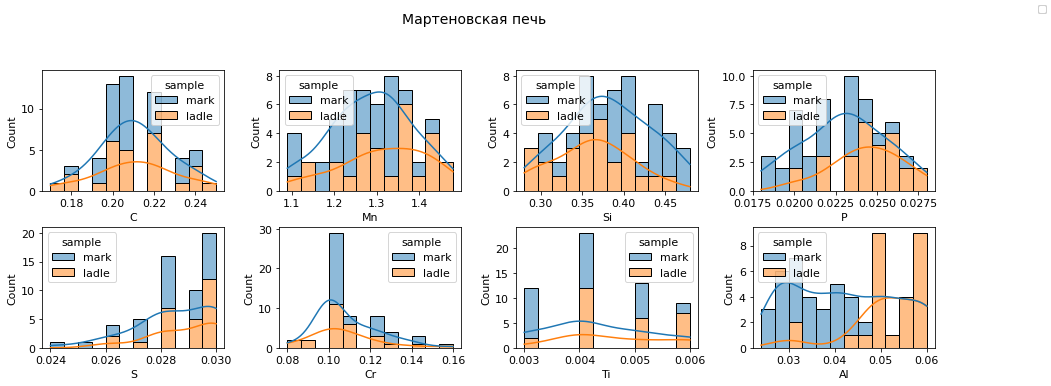

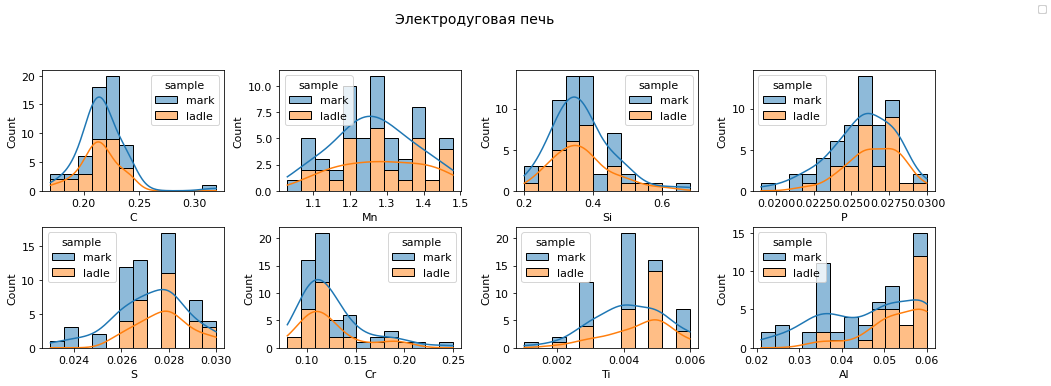

In [7]:
for furnace in samples.furnace.unique():
    frame = samples.query('furnace == @furnace')
    X = frame.drop(['melt_id', 'sample', 'furnace'], axis=1)
    y = frame['sample']
    histplot(X, y)
    plt.suptitle('Мартеновская печь' if furnace == 'open-hearth' else 'Электродуговая печь', fontsize=14)

Распределение многих элементов отличается от нормального. В данных имеются выбросы.

In [8]:
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

def check_outliers(x):
    '''
    Return outlier indexes using IRQ
    '''
    q1, q3 = np.quantile(x, 0.25), np.quantile(x, 0.75)
    iqr = stats.iqr(x)
    return ((x < (q1-1.5*iqr)) | (x > (q3+1.5*iqr)))

def diff_test(a, b):
    '''
    Calculates the T-test for the means of two independent samples or the Mann-Whitney U rank test 
    on two independent samples depends on the data distribution and outliers present
    '''
    outliers = list(map(lambda x: any(check_outliers(x)), [a, b]))
    p = [stats.shapiro(a).pvalue, stats.shapiro(b).pvalue]
    test = 'Mannwhitneyu' if any(np.hstack([np.array(p) < 0.05, outliers])) else 'Ttest'
    res = stats.ttest_ind(a, b) if test == 'Ttest' else stats.mannwhitneyu(a, b)
    return res + (test,)

res = []

for furnace in samples.furnace.unique():
    for var in samples.drop(['melt_id', 'furnace', 'sample'], axis=1).columns:
        stat, p, test = diff_test(samples.query('furnace == @furnace & sample == "mark"')[var].to_list(), 
                                  samples.query('furnace == @furnace & sample == "ladle"')[var].to_list())
        res.append([furnace, var, test, stat, p])
        
res = pd.DataFrame(res, columns=['furnace', 'feature', 'test', 'stat', 'p_value'])
reject, p_adjust, a1, a2 = multipletests(res.p_value, alpha = 0.05, method = 'fdr_bh')
res = res.assign(p_adjust=p_adjust, null_reject=reject)

with pd.option_context('precision', 2):
    print(res.sort_values(['null_reject', 'furnace'], ascending=False))

        furnace feature          test    stat   p_value  p_adjust  null_reject
1   open-hearth      Mn         Ttest   -2.29  2.58e-02  4.59e-02         True
2   open-hearth      Si         Ttest    2.95  4.70e-03  1.88e-02         True
3   open-hearth       P         Ttest   -4.56  2.87e-05  1.53e-04         True
6   open-hearth      Ti  Mannwhitneyu  264.00  1.85e-02  4.24e-02         True
7   open-hearth      Al  Mannwhitneyu   42.50  6.68e-09  1.07e-07         True
11          EAF       P  Mannwhitneyu  261.50  7.86e-03  2.10e-02         True
12          EAF       S  Mannwhitneyu  259.50  6.63e-03  2.10e-02         True
14          EAF      Ti  Mannwhitneyu  291.50  2.42e-02  4.59e-02         True
15          EAF      Al  Mannwhitneyu  135.00  4.89e-06  3.92e-05         True
0   open-hearth       C  Mannwhitneyu  383.00  7.26e-01  7.75e-01        False
4   open-hearth       S  Mannwhitneyu  301.00  8.60e-02  1.38e-01        False
5   open-hearth      Cr  Mannwhitneyu  444.00  5.08e

На уровне значимости α = 0.05 концентрация Mn, Si, P, Ti и Al в ковшевой и маркировочной пробах значимо различается в стали мартеновской плавки, концентрация P, S, Ti и Al – в стали электродуговой плавки. Для остальных элементов полученных данных не достаточно, чтобы подтвердить значимость различий. 

## Доля брака в зависимости от типа печи

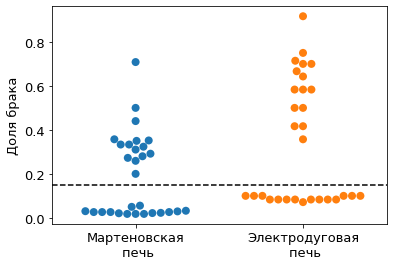

In [9]:
data = data.assign(defect_rate = data.n_defects / data.n_items)

plt.rcParams['font.size'] = 13
plt.figure(figsize=(6,4))

sns.swarmplot(x='furnace', y='defect_rate', 
              data=data.replace({'open-hearth': 'Мартеновская\n печь', 'EAF': 'Электродуговая\n печь'}), 
              size=8)
plt.axhline(0.15, ls='--', c='k')
plt.xlabel('')
plt.ylabel('Доля брака');

При плавке стали в мартеновской печи доля брака в среднем несколько ниже. Имеются плавки с долей брака близкой к нулю.

In [10]:
data['defect_risk'] = data['defect_rate'].apply(lambda x: 'high' if x > 0.15 else 'low')

Новая переменная определяет плавки с высокой и низкой долей брака.

## Шансы брака в зависимости от состава металла в ковше

In [11]:
frame = samples.merge(data[['melt_id', 'defect_risk']].replace({'defect_risk': {'low': 0, 'high': 1}}), 
                      on='melt_id').drop('melt_id', axis=1)
float64_cols = list(frame.select_dtypes(include='float64'))
frame[float64_cols] = frame[float64_cols].astype('float32')
frame[['sample', 'furnace']] = frame[['sample', 'furnace']].astype('object')

print(frame.sample(5))

        C    Mn    Si      P      S    Cr     Ti     Al sample      furnace  \
72   0.24  1.40  0.45  0.028  0.030  0.14  0.005  0.060  ladle          EAF   
106  0.22  1.30  0.34  0.026  0.028  0.20  0.004  0.060  ladle          EAF   
16   0.22  1.34  0.46  0.018  0.029  0.12  0.006  0.039   mark  open-hearth   
107  0.18  1.03  0.23  0.019  0.028  0.10  0.004  0.060   mark          EAF   
22   0.21  1.22  0.31  0.023  0.029  0.12  0.003  0.025   mark  open-hearth   

     defect_risk  
72             0  
106            1  
16             0  
107            1  
22             0  


In [12]:
import statsmodels.formula.api as smf

In [13]:
formula = frame.columns[-1] + '~' + '+'.join(frame.columns[:-1])
fit_full = smf.logit(formula, data=frame).fit(cov_type='hc1')
print(fit_full.summary())

Optimization terminated successfully.
         Current function value: 0.590143
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            defect_risk   No. Observations:                  116
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                           10
Date:                Thu, 09 Jun 2022   Pseudo R-squ.:                  0.1486
Time:                        21:28:47   Log-Likelihood:                -68.457
converged:                       True   LL-Null:                       -80.405
Covariance Type:                  hc1   LLR p-value:                  0.007878
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 20.1418      6.119      3.292      0.001       8.149      

По значениям статистической ошибки первого рода для коэффициентов регрессии можно видеть, что ни один параметр, за исключением S, не вносит значимого вклада в модель. 

In [14]:
fit_reduced = smf.logit('defect_risk ~ S', data=frame).fit(cov_type='hc1')
print(fit_reduced.summary())

Optimization terminated successfully.
         Current function value: 0.626377
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            defect_risk   No. Observations:                  116
Model:                          Logit   Df Residuals:                      114
Method:                           MLE   Df Model:                            1
Date:                Thu, 09 Jun 2022   Pseudo R-squ.:                 0.09633
Time:                        21:28:48   Log-Likelihood:                -72.660
converged:                       True   LL-Null:                       -80.405
Covariance Type:                  hc1   LLR p-value:                 8.291e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.7898      3.900      3.536      0.000       6.145      21.434
S           -494.1422    139.

В сокращенной модели коэффициенты регрессии статистически значимы.

In [15]:
import rpy2
print(rpy2.__version__)
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
r_stats = importr('stats')
base = importr('base')
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

3.5.2


In [16]:
with localconverter(ro.default_converter + pandas2ri.converter):
    r_frame = ro.conversion.py2rpy(frame)

In [17]:
r_fit_full = r_stats.glm(formula='defect_risk ~ .', data=r_frame, family='binomial')
r_fit_reduced = r_stats.glm(formula='defect_risk ~ S', data=r_frame, family='binomial')
print(r_stats.anova(r_fit_full, r_fit_reduced, test='Chisq'))

Analysis of Deviance Table

Model 1: defect_risk ~ C + Mn + Si + P + S + Cr + Ti + Al + sample + furnace
Model 2: defect_risk ~ S
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)
1       105     136.91                     
2       114     145.32 -9  -8.4063   0.4938



Незначимая величина критерия хи-квадрат свидетельствует о том, что сокращенная модель соответствует данным так же хорошо, как и модель с полным набором независимых переменных. </br>
Концентрация S в ковше значимо влияет на шансы получить высокую или низкую долю забракованных отливок.

In [18]:
np.random.seed(0) 

R = 1000
row_id = range(0, frame.shape[0])
res_boot = np.zeros((R, 2))

for r in range(R):
    samples = np.random.choice(row_id, size=frame.shape[0], replace=True)
    frame_r = frame.iloc[samples]
    res_r = smf.logit('defect_risk ~ S', data=frame_r).fit(disp=0).params
    res_boot[r,:] = np.asarray(res_r)
    
res_boot = pd.DataFrame(res_boot, columns=['Intercept','S'])

with pd.option_context('precision', 2):
    print(res_boot.describe(percentiles=[.025,.975]))

       Intercept        S
count    1000.00  1000.00
mean       14.52  -519.90
std         4.07   145.49
min         0.22 -1166.89
2.5%        7.38  -829.24
50%        14.16  -506.83
97.5%      23.24  -265.49
max        32.70    -6.66


In [19]:
np.exp(res_boot.S.mean())**1e-3

0.5945819266276142

Увеличение концентрации S на 0.001% изменяет отношение шансов примерно в 0.6 раза.

## Состав шихты для плавки

In [37]:
frame_0 = data.filter(like='_0').drop(['Ni_0', 'Cu_0'], axis=1)
frame_1 = data.filter(like='_1')
frame_2 = data.filter(like='_2')
frame_3 = data.filter(like='_3').drop(['Ti_3', 'Al_3'], axis=1)
frame = data.loc[:,'C':'Cr']

deviation_0 = pd.DataFrame((frame_0.values - frame.values) / frame.values, columns=frame.columns)
deviation_1 = pd.DataFrame((frame_1.values - frame.values) / frame.values, columns=frame.columns)
deviation_2 = pd.DataFrame((frame_2.values - frame.values) / frame.values, columns=frame.columns)
deviation_3 = pd.DataFrame((frame_3.values - frame.values) / frame.values, columns=frame.columns)

deviation = pd.concat([
    pd.concat([
        deviation_0.assign(sample=0), 
        deviation_1.assign(sample=1), 
        deviation_2.assign(sample=2), 
        deviation_3.assign(sample=3), 
    ], axis=0),
    pd.concat([data[['melt_id', 'furnace', 'defect_risk']]]*4)
], axis=1)

deviation_long = pd.melt(deviations, 
                          value_vars=list(frame.columns), 
                          id_vars=['melt_id','furnace','sample', 'defect_risk'], 
                          var_name='feature', 
                          value_name='deviation')

print(deviation_long.sample(5))

     melt_id      furnace  sample defect_risk feature  deviation
260    374-1  open-hearth       0        high      Mn  -0.923664
598    7-824          EAF       1        high      Si  -0.970588
87     398-1  open-hearth       1        high       C  -0.157895
1232   6-713          EAF       0         low      Cr  -0.111111
341    7-740          EAF       1         low      Mn  -0.796296


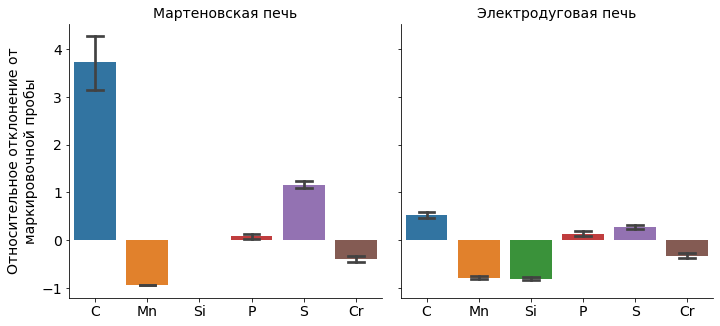

In [38]:
plt.rcParams['font.size'] = 14

g = sns.catplot(
    x='feature', y='deviation', col='furnace', kind ='bar', capsize=0.3, 
    data=deviation_long.query('sample == 0')\
    .replace({'open-hearth': 'Мартеновская печь', 'EAF': 'Электродуговая печь'})
)
g.set_axis_labels('', 'Относительное отклонение от\nмаркировочной пробы')\
.set_titles('{col_name}');

Шихта для мартеновской плавки содержит значительно больше C и S, и концентрация C варьируется в значительно бóльших пределах. В ходе плавки снижаются концентрации C, P, S, повышаются концентрации Mn, Si и Cr.

## Окисление углерода

In [22]:
data = data.assign(deoxid = lambda x: x.C_0 - x.C_1)

In [115]:
deox_subset = data.query('defect_risk == "high"')[['furnace', 'deoxid', 'defect_rate']]

for furnace in data.furnace.unique():
    frame = deox_subset.query('furnace == @furnace').drop('furnace', axis=1)
    idx = frame.index[frame.apply(lambda x: check_outliers(x), axis=0).apply(any, axis=1)]
    deox_subset = deox_subset.drop(idx, axis=0)

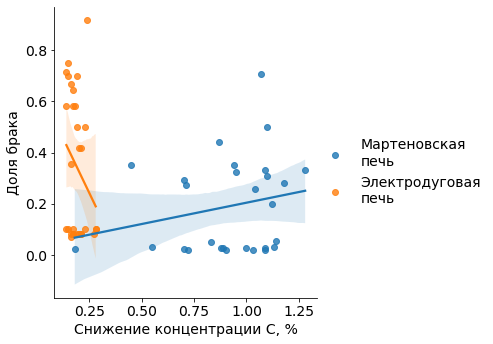

In [117]:
g = sns.lmplot(
    x='deoxid', y='defect_rate', hue='furnace', 
    data=deox_subset.replace({'furnace': {'open-hearth': 'Мартеновская\nпечь', 'EAF': 'Электродуговая\nпечь'}})
)
g.set_axis_labels('Снижение концентрации C, %', 'Доля брака').legend.set_title('')

In [125]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [126]:
deox_lm = ols(formula='defect_rate ~ deoxid * furnace', data=data).fit()
print(sm.stats.anova_lm(deox_lm, typ=2))

                  sum_sq    df         F    PR(>F)
furnace         0.172618   1.0  3.089397  0.084269
deoxid          0.009204   1.0  0.164724  0.686391
deoxid:furnace  0.150256   1.0  2.689183  0.106638
Residual        3.128963  56.0       NaN       NaN


## Десульфурация

In [127]:
data = data.assign(desulf = lambda x: x.S_0 - x.S_1)

In [128]:
desulf_subset = data.query('defect_risk == "high"')[['furnace', 'desulf', 'defect_rate']]

for furnace in data.furnace.unique():
    frame = desulf_subset.query('furnace == @furnace').drop('furnace', axis=1)
    idx = frame.index[frame.apply(lambda x: check_outliers(x), axis=0).apply(any, axis=1)]
    desulf_subset = desulf_subset.drop(idx, axis=0)

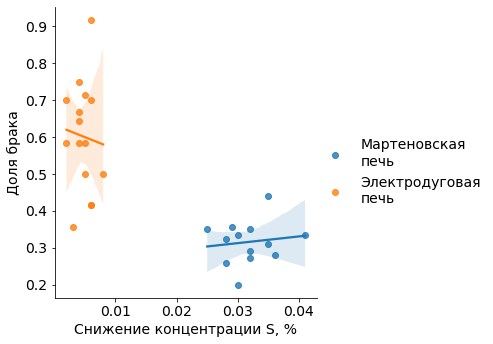

In [130]:
g = sns.lmplot(
    x='desulf', y='defect_rate', hue='furnace', 
    data=desulf_subset.replace({'furnace': {'open-hearth': 'Мартеновская\nпечь', 'EAF': 'Электродуговая\nпечь'}}))
g.set_axis_labels('Снижение концентрации S, %', 'Доля брака').legend.set_title('')

In [131]:
desulf_lm = ols(formula='defect_rate ~ desulf * furnace', data=data).fit()
print(sm.stats.anova_lm(desulf_lm, typ=2))

                  sum_sq    df         F    PR(>F)
furnace         0.150761   1.0  2.669714  0.107885
desulf          0.065136   1.0  1.153449  0.287434
desulf:furnace  0.060922   1.0  1.078825  0.303425
Residual        3.162365  56.0       NaN       NaN
